### Multi-Label Classification

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
import numpy as np

### torchvision.datasets.MNIST

In [3]:
train_rawdata = datasets.MNIST(root = 'dataset',
                            train=True,
                            download=True,
                            transform=transforms.ToTensor())
test_dataset = datasets.MNIST(root = 'dataset',
                            train=False,
                            download=True,
                            transform=transforms.ToTensor())
print('Number of training data : ', len(train_rawdata))
print('Number of test data : ', len(test_dataset))

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9912422/9912422 [00:00<00:00, 12090696.92it/s]


Extracting dataset\MNIST\raw\train-images-idx3-ubyte.gz to dataset\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28881/28881 [00:00<00:00, 5251016.25it/s]

Extracting dataset\MNIST\raw\train-labels-idx1-ubyte.gz to dataset\MNIST\raw



Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1648877/1648877 [00:00<00:00, 10986603.94it/s]


Extracting dataset\MNIST\raw\t10k-images-idx3-ubyte.gz to dataset\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4542/4542 [00:00<00:00, 4529369.65it/s]

Extracting dataset\MNIST\raw\t10k-labels-idx1-ubyte.gz to dataset\MNIST\raw

Number of training data :  60000
Number of test data :  10000


### Validation dataset

In [4]:
VALIDATION_RATE = 0.2
train_indices, val_indices, _, _ = train_test_split(
    range(len(train_rawdata)), # X index
    train_rawdata.targets, # y
    stratify=train_rawdata.targets, 
    test_size=VALIDATION_RATE # test dataset
)

### Validation dataset using torch.utils.data.Subset

In [5]:
train_dataset = Subset(train_rawdata, train_indices)
validation_dataset = Subset(train_rawdata, val_indices)

### dataset size 

In [6]:
print (len(train_dataset), len(validation_dataset), len(test_dataset))

48000 12000 10000


### Mini-batch

In [7]:
BATCH_SIZE = 128
# create batches
train_batches = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_batches = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_batches = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

### Visualization

In [8]:
X_train, y_train = next(iter(train_batches))
print (X_train.shape, y_train.shape)
index = 1
X_train[index, :, :, :].shape

torch.Size([128, 1, 28, 28]) torch.Size([128])


torch.Size([1, 28, 28])

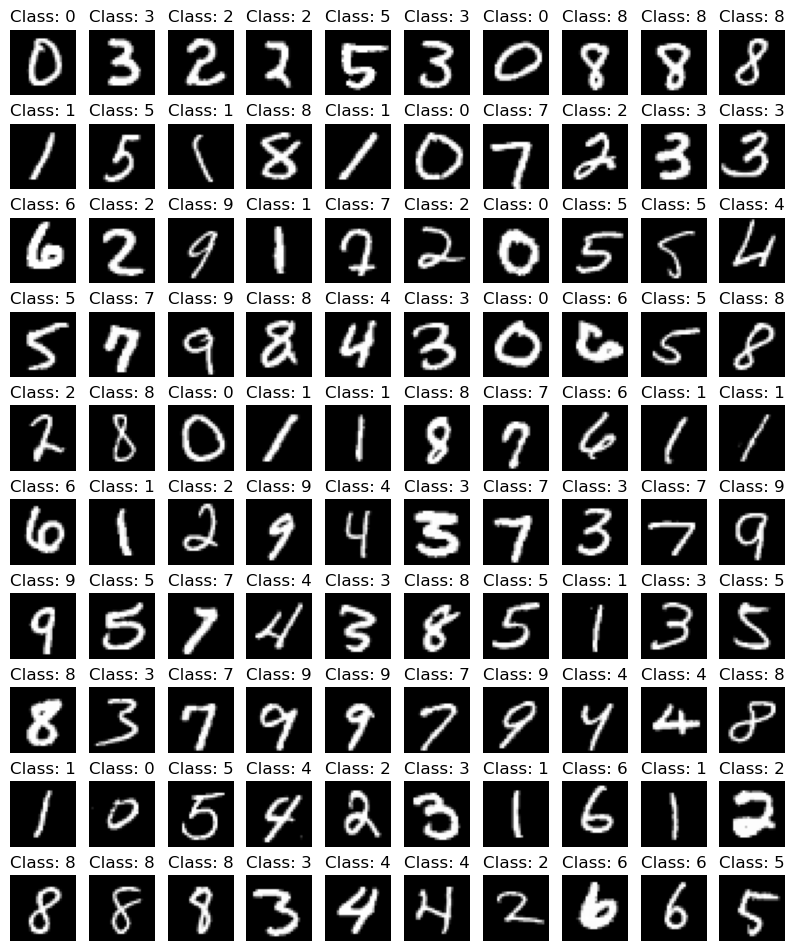

In [9]:
# Print 100 images
import matplotlib.pyplot as plt
%matplotlib inline 

plt.figure(figsize=(10 , 12))

X_train, y_train = next(iter(train_batches))
for index in range(100):
    plt.subplot(10, 10, index + 1)
    plt.axis('off')
    plt.imshow(X_train[index, :, :, :].numpy( ).reshape(28,28), cmap = "gray")
    plt.title('Class: ' + str(y_train[index].item()))

### Model

In [10]:
class FunModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        
        self.linear_layers = nn.Sequential (
            nn.Linear(input_dim, 256),
            nn.LeakyReLU(0.1),
            nn.Linear(256, 256),
            nn.LeakyReLU(0.1),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.1),
            nn.Linear(128, output_dim),
            nn.LogSoftmax(dim=-1)
        )
        
    def forward(self, x):
        y = self.linear_layers(x)
        return y

minibatch_size = 128
input_dim = 28 * 28 
output_dim = 10
model = FunModel(input_dim, output_dim)  

loss_func = nn.NLLLoss() 
optimizer = torch.optim.Adam(model.parameters())

### Save the best model

In [11]:
from copy import deepcopy

In [12]:
def train_model(model, early_stop, n_epochs, progress_interval):
    
    train_losses, valid_losses, lowest_loss = list(), list(), np.inf

    for epoch in range(n_epochs):
        
        train_loss, valid_loss = 0, 0
        
        # train the model
        model.train() # prep model for training
        for x_minibatch, y_minibatch in train_batches:
            y_minibatch_pred = model(x_minibatch.view(x_minibatch.size(0), -1))
            loss = loss_func(y_minibatch_pred, y_minibatch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        train_loss = train_loss / len(train_batches)
        train_losses.append(train_loss)      
        
        # validate the model
        model.eval()
        with torch.no_grad():
            for x_minibatch, y_minibatch in val_batches:
                y_minibatch_pred = model(x_minibatch.view(x_minibatch.size(0), -1))
                loss = loss_func(y_minibatch_pred, y_minibatch)
                valid_loss += loss.item()
                
        valid_loss = valid_loss / len(val_batches)
        valid_losses.append(valid_loss)

        if valid_losses[-1] < lowest_loss:
            lowest_loss = valid_losses[-1]
            lowest_epoch = epoch
            best_model = deepcopy(model.state_dict())
        else:
            if (early_stop > 0) and lowest_epoch + early_stop < epoch:
                print ("Early Stopped", epoch, "epochs")
                break
                
        if (epoch % progress_interval) == 0:
            print (train_losses[-1], valid_losses[-1], lowest_loss, lowest_epoch, epoch)
            
    model.load_state_dict(best_model)        
    return model, lowest_loss, train_losses, valid_losses

### Final evaluation

In [13]:
test_loss = 0
correct = 0
wrong_samples, wrong_preds, actual_preds = list(), list(), list()

model.eval()
with torch.no_grad():
    for x_minibatch, y_minibatch in test_batches:
        y_test_pred = model(x_minibatch.view(x_minibatch.size(0), -1))
        test_loss += loss_func(y_test_pred, y_minibatch)  
        pred = torch.argmax(y_test_pred, dim=1)
        correct += pred.eq(y_minibatch).sum().item()
        
        wrong_idx = pred.ne(y_minibatch).nonzero()[:, 0].numpy().tolist()
        for index in wrong_idx:
            wrong_samples.append(x_minibatch[index])
            wrong_preds.append(pred[index])
            actual_preds.append(y_minibatch[index])
            
test_loss /= len(test_batches.dataset)
print('Average Test Loss: {:.4f}'.format( test_loss ))
print('Accuracy: {}/{} ({:.2f}%)'.format( correct, len(test_batches.dataset), 100 * correct / len(test_batches.dataset) ))

Average Test Loss: 0.0182
Accuracy: 1041/10000 (10.41%)


### Print the incorrect data

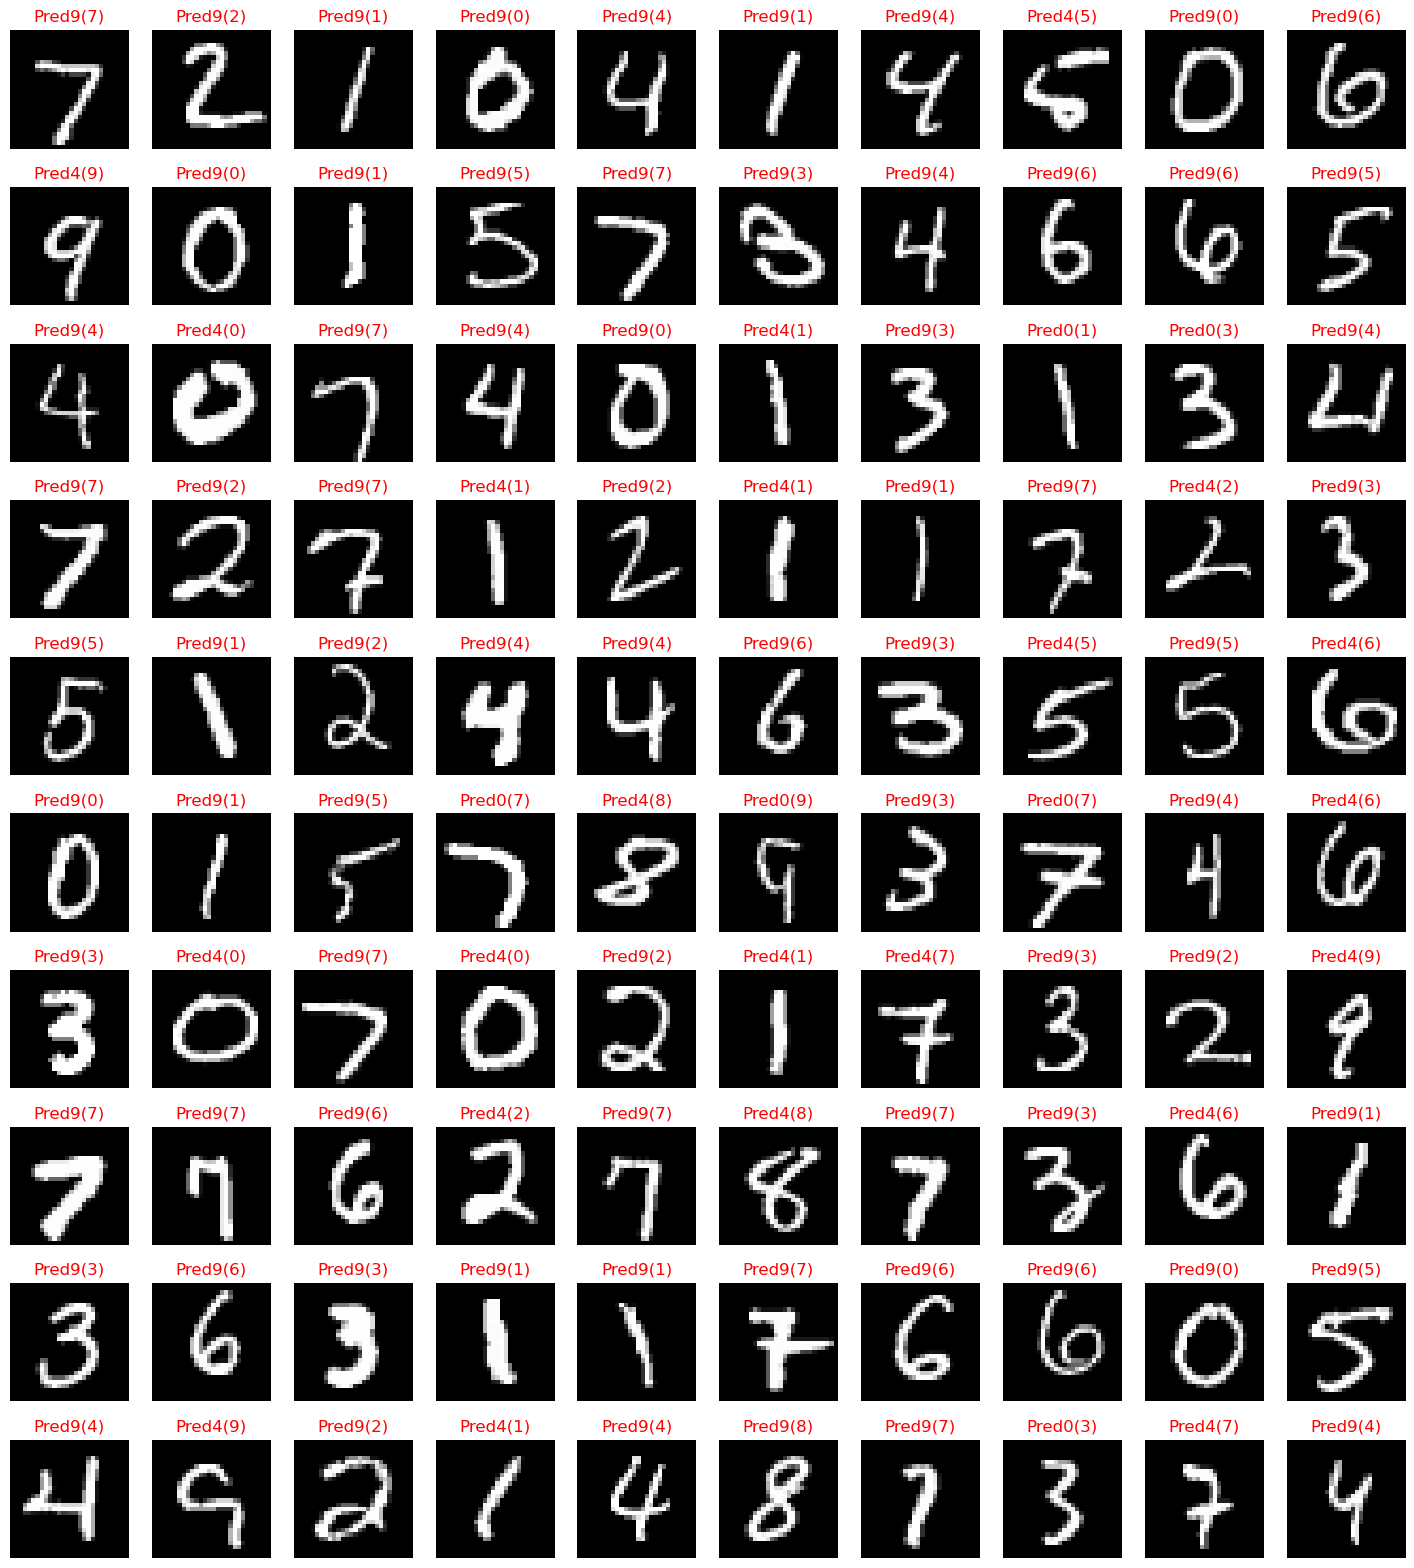

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.figure(figsize=(18 , 20))

for index in range(100):
    plt.subplot(10, 10, index + 1)
    plt.axis('off')
    plt.imshow(wrong_samples[index].numpy( ).reshape(28,28), cmap = "gray")
    plt.title("Pred" + str(wrong_preds[index].item()) + "(" + str(actual_preds[index].item()) + ")", color='red')